In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [5]:
titanic_data = pd.read_csv("./datasets/titanic/train.csv")
titanic_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [6]:
from sklearn.model_selection import StratifiedShuffleSplit

# Crear el objeto de división estratificada
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=24)

# Aplicar la división basada en 'categoria_income'
for train_index, test_index in split.split(titanic_data, titanic_data[["Survived", "Pclass", "Sex"]]):
    df = titanic_data.loc[train_index]
    df_test = titanic_data.loc[test_index]

print("Tamaño del conjunto de entrenamiento:", len(df))
print("Tamaño del conjunto de prueba:", len(df_test))

Tamaño del conjunto de entrenamiento: 712
Tamaño del conjunto de prueba: 179


In [7]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler


# Agrupar columnas por tipo de transformación
scaled_num_features = ["Age", "Fare"]
unscaled_num_features = ["Pclass", "SibSp", "Parch"]
cat_features = ["Embarked", "Sex"]


# Crear transformadores individuales
# Pipelínes por tipo
scaled_num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

unscaled_num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median"))
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ("onehot", OneHotEncoder(sparse_output=False, handle_unknown='ignore',
                             categories=[["C", "Q", "S"], ["female", "male"]]))
])

# ColumnTransformer final
preprocessor = ColumnTransformer([
    ("scaled_num", scaled_num_pipeline, scaled_num_features),
    ("unscaled_num", unscaled_num_pipeline, unscaled_num_features),
    ("cat", cat_pipeline, cat_features)
], remainder="drop")

In [ ]:
# 1. Definir X e y a partir del conjunto estratificado
X_train = df.drop("Survived", axis=1)
y_train = df["Survived"]

X_test = df_test.drop("Survived", axis=1)
y_test = df_test["Survived"]

# 2. Aplicar preprocesamiento al conjunto de entrenamiento
X_train_transformed = preprocessor.fit_transform(X_train)

# 3. Aplicar al conjunto de test con transform
X_test_transformed = preprocessor.transform(X_test)

# 4. Utiliamos para volver a un Dataframe los nombres automaticos
X_columns = preprocessor.get_feature_names_out()
X_columns = X_columns.tolist()
print(X_columns)

X_train_final = pd.DataFrame(X_train_transformed, columns=X_columns, index=X_train.index)
X_test_final = pd.DataFrame(X_test_transformed, columns=X_columns, index=X_test.index)


['scaled_num__Age', 'scaled_num__Fare', 'unscaled_num__Pclass', 'unscaled_num__SibSp', 'unscaled_num__Parch', 'cat__Embarked_C', 'cat__Embarked_Q', 'cat__Embarked_S', 'cat__Sex_female', 'cat__Sex_male']


array([[<Axes: title={'center': 'scaled_num__Age'}>,
        <Axes: title={'center': 'scaled_num__Fare'}>]], dtype=object)

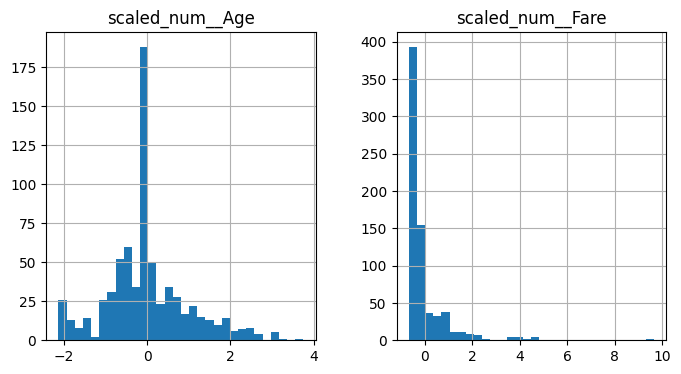

In [11]:
X_train_final.isna().sum().sum()
X_train_final[["scaled_num__Age","scaled_num__Fare"]].hist(figsize=(8, 4), bins=30)

In [12]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold


logreg = LogisticRegression(max_iter=1000)
# Cross-validation estratificada
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(logreg, X_train_final, y_train, cv=cv, scoring="accuracy")

print(f"Accuracy por fold: {scores}")
print(f"Media: {scores.mean():.4f}")

Accuracy por fold: [0.79020979 0.76923077 0.82394366 0.73943662 0.84507042]
Media: 0.7936


In [ ]:
#Optimizar los hiperparametros del modelo
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Dos subrejillas porque cada solver admite penalizaciones distintas
param_grid = [
    {   # liblinear: l1 o l2
        "solver": ["liblinear"],
        "penalty": ["l1", "l2"],
        "C": np.logspace(-3, 3, 13),   # 0.001 ... 1000
        "class_weight": [None, "balanced"]
    },
    {   # saga: l1, l2 o elasticnet (con l1_ratio)
        "solver": ["saga"],
        "penalty": ["l1", "l2", "elasticnet"],
        "l1_ratio": [None, 0.3, 0.5, 0.7],  # None se ignora salvo elasticnet
        "C": np.logspace(-3, 3, 13),
        "class_weight": [None, "balanced"],
        "max_iter": [2000]  # saga suele necesitar más iteraciones
    }
]

logreg = LogisticRegression(max_iter=1000)

# Escoge la métrica objetivo. En Titanic suele ir bien 'roc_auc' o 'f1'
grid = GridSearchCV(
    estimator=logreg,
    param_grid=param_grid,
    scoring="roc_auc",
    cv=cv,
    n_jobs=-1,
    verbose=0,
    refit=True     # reentrena en todo X_train_final con los mejores hiperparámetros
)

grid.fit(X_train_final, y_train)

print("Mejores params:", grid.best_params_)
print("Mejor AUC CV:", grid.best_score_)
best_logreg = grid.best_estimator_


In [13]:
# Entrenar
from sklearn.metrics import accuracy_score

logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train_final, y_train)

y_pred = logreg.predict(X_test_final)
# Métrica de rendimiento
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy en test: {acc:.4f}")


Accuracy en test: 0.8101


In [17]:
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, classification_report

y_pred = best_logreg.predict(X_test_final)
y_proba = best_logreg.predict_proba(X_test_final)[:,1]

print("Accuracy test:", accuracy_score(y_test, y_pred))
print("F1 test:", f1_score(y_test, y_pred))
print("ROC AUC test:", roc_auc_score(y_test, y_proba))
print(classification_report(y_test, y_pred))


Accuracy test: 0.8268156424581006
F1 test: 0.7596899224806202
ROC AUC test: 0.8532061473237943
              precision    recall  f1-score   support

           0       0.84      0.89      0.86       111
           1       0.80      0.72      0.76        68

    accuracy                           0.83       179
   macro avg       0.82      0.81      0.81       179
weighted avg       0.83      0.83      0.82       179



In [20]:
import numpy as np

coef_df = pd.DataFrame({
    "Variable": X_train_final.columns,
    "Coeficiente": best_logreg.coef_[0],
    "Exp(B)": np.exp(best_logreg.coef_[0])  # odds ratio
}).sort_values(by="Coeficiente", ascending=False)

print(coef_df)


               Variable  Coeficiente    Exp(B)
8       cat__Sex_female     0.800476  2.226601
1      scaled_num__Fare     0.196137  1.216693
6       cat__Embarked_Q     0.068197  1.070576
5       cat__Embarked_C     0.066511  1.068773
4   unscaled_num__Parch     0.028119  1.028518
7       cat__Embarked_S    -0.133716  0.874839
3   unscaled_num__SibSp    -0.206119  0.813736
0       scaled_num__Age    -0.300919  0.740138
2  unscaled_num__Pclass    -0.624433  0.535565
9         cat__Sex_male    -0.799484  0.449561


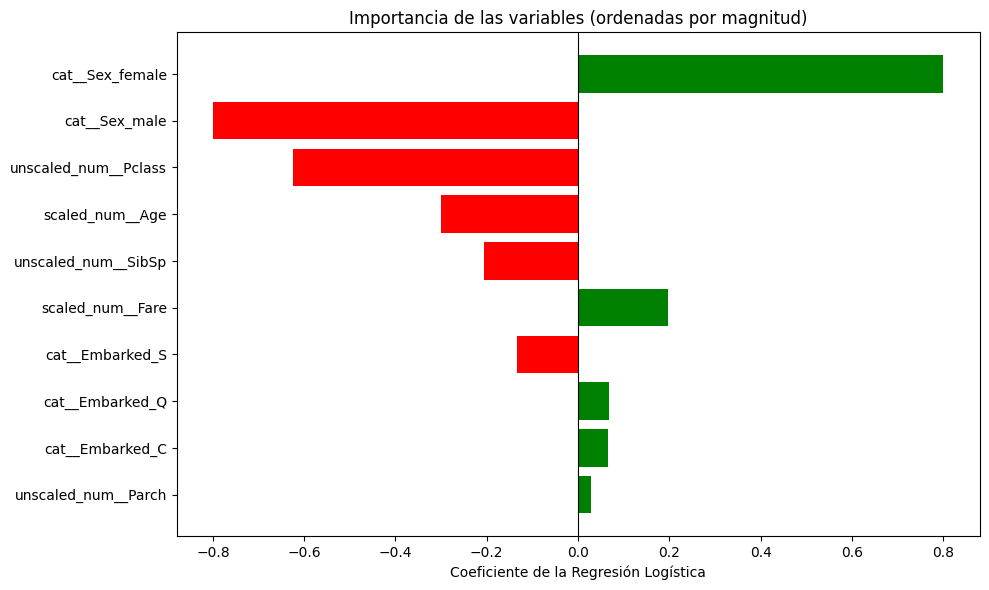

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Obtener nombres de variables y coeficientes del modelo
coef = best_logreg.coef_[0]
features = X_train_final.columns  # Asegúrate de que X_train_final conserve nombres tras el pipeline

# DataFrame con coeficientes y odds ratio
coef_df = pd.DataFrame({
    "Variable": features,
    "Coeficiente": coef,
    "Odds_ratio": np.exp(coef)
})

# Ordenar por magnitud absoluta del coeficiente
coef_df = coef_df.reindex(coef_df["Coeficiente"].abs().sort_values(ascending=False).index)

# Graficar
plt.figure(figsize=(10, 6))
bars = plt.barh(coef_df["Variable"], coef_df["Coeficiente"], color=np.where(coef_df["Coeficiente"] > 0, "green", "red"))
plt.axvline(x=0, color="black", linewidth=0.8)
plt.xlabel("Coeficiente de la Regresión Logística")
plt.title("Importancia de las variables (ordenadas por magnitud)")
plt.gca().invert_yaxis()  # Variable más importante arriba
plt.tight_layout()
plt.show()


[[99 12]
 [19 49]]


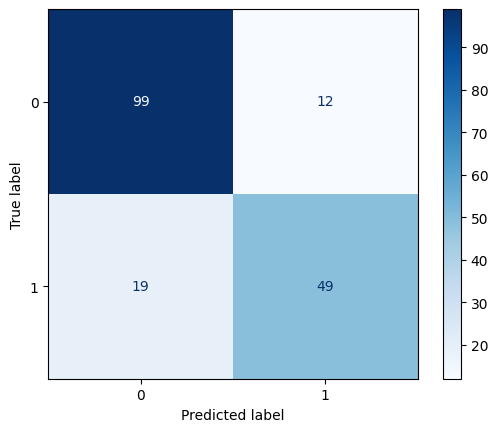

In [19]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# Mostrarla en texto
print(cm)

# Mostrarla como gráfico
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_logreg.classes_)
disp.plot(cmap="Blues")
